In [17]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import json
import random

import requests
import time
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

import networkx as nx

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
## This is the file to load the UMLS CUI mappings

file_path = '/content/drive/MyDrive/NLP_project_files/code_file/cui_mappings.json' # Change this to path where your cui_mappings.json is stored

with open(file_path, 'r') as file:
    cui_mappings = json.load(file)

# cui_mappings

In [12]:
# UMLS API key

api_key = 'd956f4f9-ab67-4620-a4f2-d5e74e91cad1'

retry_strategy = Retry(
    total=3,  # Total number of retries
    status_forcelist=[429, 500, 502, 503, 504],  # Status codes to trigger a retry
    allowed_methods=["HEAD", "GET", "OPTIONS"],  # HTTP methods to retry on
    backoff_factor=1  # Wait time between retries
)

adapter = HTTPAdapter(max_retries=retry_strategy)

session = requests.Session()
session.mount('https://', adapter)
session.mount('http://', adapter)

def get_tgt(api_key):
    params = {'apikey': api_key}
    response = requests.post('https://utslogin.nlm.nih.gov/cas/v1/api-key', data=params)
    if response.status_code == 201:
        return response.headers['Location']
    raise Exception('Could not get TGT: ' + response.text)

def get_service_ticket(tgt):
    params = {'service': 'http://umlsks.nlm.nih.gov'}
    response = requests.post(tgt, data=params)
    if response.status_code == 200:
        return response.text
    raise Exception('Could not get service ticket: ' + response.text)

def search_term_get_cui_and_score(term, st, session):
    url = 'https://uts-ws.nlm.nih.gov/rest/search/current'
    params = {'string': term, 'ticket': st}
    response = session.get(url, params=params)
    if response.status_code == 200:
        results = response.json()
        try:
            cui = results['result']['results'][0]['ui']
            # Using the number of results as a simple relevance score
            relevance_score = len(results['result']['results'])
            return cui, relevance_score
        except (IndexError, KeyError):
            return None, 0
    raise Exception('Could not search term: ' + response.text)

# Function to get relationships for a specific CUI
def get_cui_relationships(cui, st, session):
    url = f'https://uts-ws.nlm.nih.gov/rest/content/current/CUI/{cui}/relations'
    params = {'ticket': st}
    response = session.get(url, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f'Error retrieving relationships for CUI {cui}: {response.text}')

In [13]:
# Determine the number of CUIs to sample (This value can be played around with)
num_cuis_to_sample = min(2000, len(cui_mappings))

# Randomly select CUIs from the dictionary
selected_cuis = random.sample(list(cui_mappings.values()), num_cuis_to_sample)

cui_relationships = {}

try:
    tgt = get_tgt(api_key)

    for cui in selected_cuis:
        st = get_service_ticket(tgt)
        relationships = get_cui_relationships(cui, st, session)
        cui_relationships[cui] = relationships

        time.sleep(0.05)


except Exception as e:
    print(str(e))

Error retrieving relationships for CUI C1134719: {"name":"NotFoundError","status":404,"message":"404 Resource Not Found"}


In [15]:
cui_related_terms = {}

for cui, cui_data in cui_relationships.items():

    result_list = cui_data.get('result', [])


    related_terms_labels = []

    for result_entry in result_list:

        related_id_name = result_entry.get('relatedIdName')
        additional_relation_label = result_entry.get('additionalRelationLabel')


        if related_id_name and additional_relation_label:
            related_terms_labels.append((related_id_name, additional_relation_label))

    cui_related_terms[cui] = related_terms_labels

In [18]:
selected_cui_mappings = dict(list(cui_mappings.items())[:2000]) #This value can be played around with for more/less no. of entities

# Create a new directed graph
G = nx.DiGraph()

tgt = get_tgt(api_key)

cui_to_entity_name = {cui: entity for entity, cui in selected_cui_mappings.items()}

for cui in selected_cui_mappings.values():
    st = get_service_ticket(tgt)
    try:
        relationships = get_cui_relationships(cui, st, session)

        for relation in relationships.get('result', []):
            # Extract the target CUI from the relation
            target_cui = relation['relatedId'].split('/')[-1]
            relation_label = relation.get('relationLabel', '')

            # Check if both source and target CUIs are in your selected list
            if target_cui in selected_cui_mappings.values():
                source_entity_name = cui_to_entity_name.get(cui, cui)  # Fallback to CUI if name not found
                target_entity_name = cui_to_entity_name.get(target_cui, target_cui)  # Fallback to CUI if name not found

                # Add nodes and edge to the graph with the relationLabel
                G.add_node(source_entity_name)
                G.add_node(target_entity_name)
                G.add_edge(source_entity_name, target_entity_name, label=relation_label)

    except Exception as e:
        print(f"Skipping CUI {cui} due to error: {e}")

    # Pause to respect API rate limits
    time.sleep(0.05)

Skipping CUI C5705653 due to error: Error retrieving relationships for CUI C5705653: {"name":"NotFoundError","status":404,"message":"404 Resource Not Found"}
Skipping CUI C5401594 due to error: Error retrieving relationships for CUI C5401594: {"name":"NotFoundError","status":404,"message":"404 Resource Not Found"}
Skipping CUI C1968689 due to error: Error retrieving relationships for CUI C1968689: {"name":"NotFoundError","status":404,"message":"404 Resource Not Found"}
Skipping CUI C5709304 due to error: Error retrieving relationships for CUI C5709304: {"name":"NotFoundError","status":404,"message":"404 Resource Not Found"}
Skipping CUI C5416839 due to error: Error retrieving relationships for CUI C5416839: {"name":"NotFoundError","status":404,"message":"404 Resource Not Found"}
Skipping CUI C1366027 due to error: Error retrieving relationships for CUI C1366027: {"name":"NotFoundError","status":404,"message":"404 Resource Not Found"}
Skipping CUI C5761852 due to error: Error retrieving

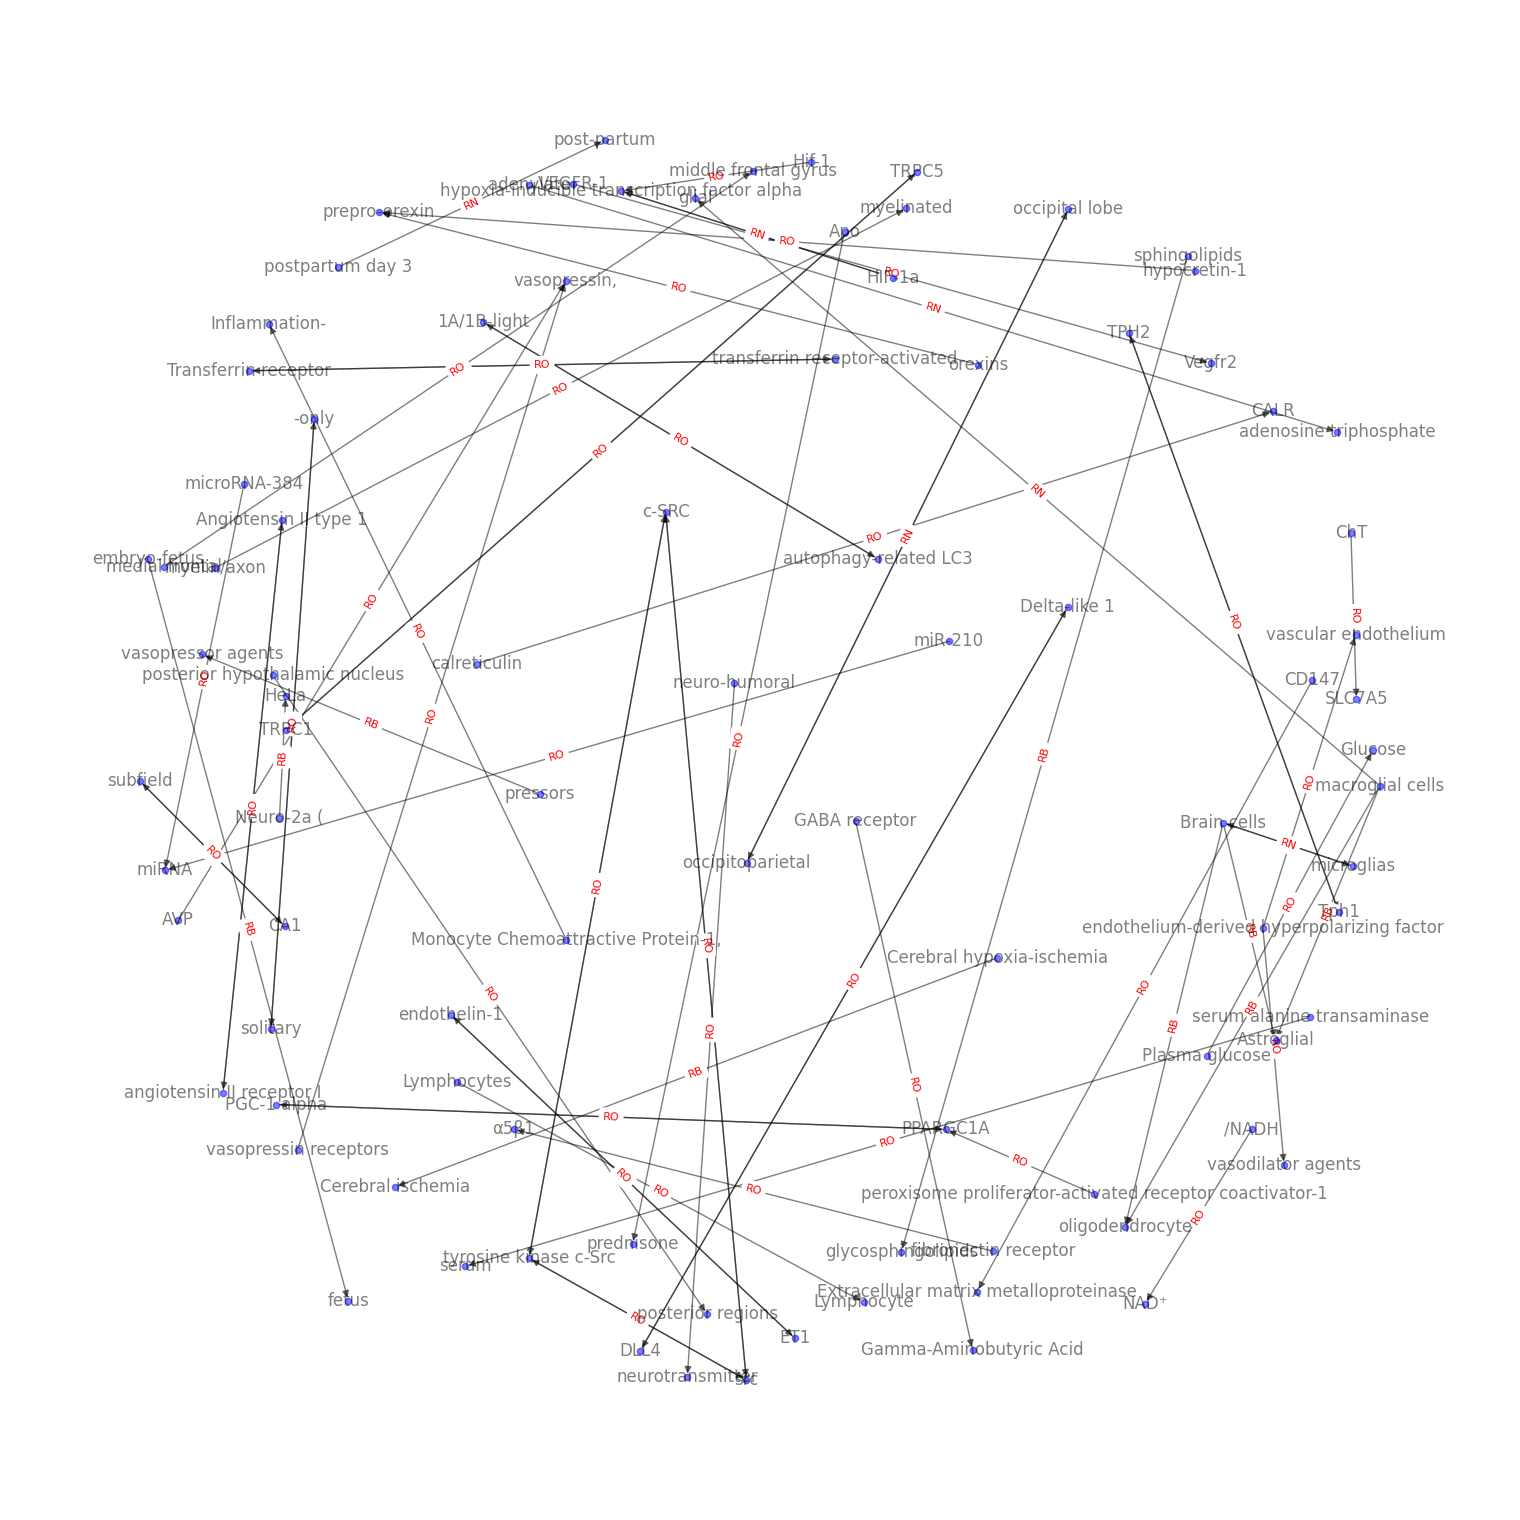

In [19]:
## Knowledge graph visualization

# Set the figure size (width, height in inches)
plt.figure(figsize=(15, 15))

pos = nx.spring_layout(G, k=0.5, iterations=20)  # Layout for the graph

# Draw nodes and edges
nx.draw(G, pos, node_size=20, node_color='blue', alpha=0.5, with_labels=True, font_size=12)

# Draw edge labels with increased font size
edge_labels = {(source, target): data['label'] for source, target, data in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)  # Increase font_size as needed

plt.show()